<a href="https://colab.research.google.com/github/rjrizani/machine-learning/blob/main/gender_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

In [2]:
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [3]:
import pandas as pd
import re
import gdown

google_drive_link = "https://drive.google.com/file/d/1wfpbNWY4S39u5GuNxBr218N_gyXmCEUv/view?usp=drive_link"
file_id = re.search(r"/d/(\w+)/", google_drive_link).group(1)

output_file = 'genderPrediction.csv'

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1wfpbNWY4S39u5GuNxBr218N_gyXmCEUv
From (redirected): https://drive.google.com/uc?id=1wfpbNWY4S39u5GuNxBr218N_gyXmCEUv&confirm=t&uuid=e6dad038-2631-499a-9dad-512b7eccc8e1
To: /content/genderPrediction.csv
100%|██████████| 200M/200M [00:02<00:00, 76.6MB/s]


'genderPrediction.csv'

In [4]:
data = pd.read_csv(output_file)
data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [6]:
data['gender'].value_counts()

,count
gender,
0,12391
1,11314


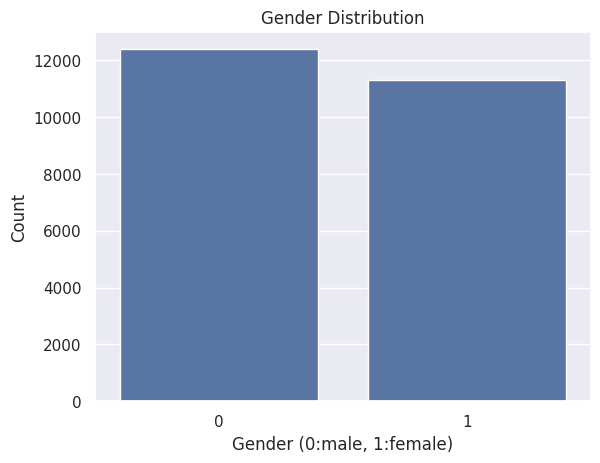

In [7]:
#make bar plot about gender,
sns.countplot(x='gender', data=data)
plt.xlabel('Gender (0:male, 1:female)')
plt.ylabel('Count')
plt.title('Gender Distribution')
plt.show()


# Formating Data

In [8]:
import numpy as np
data['pixels'] = data['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48,48))

##Define feature and target

In [9]:
images = np.array(data['pixels'].to_list())


In [10]:
labels = data['gender'].values

##Data Transformation

In [11]:
images_reshaped = images.reshape(images.shape[0], 48, 48, 1)

##Data Normalization

In [12]:
if np.max(images_reshaped) > 1:
  images_reshaped = images_reshaped / 255

# Data Splitting

In [13]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images_reshaped, labels, test_size=0.2, random_state=42)

In [14]:
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

In [28]:
#print the size of the resulting sets
print("Training set size:", len(train_images))
print("Validation set size:", len(val_images))
print("Testing set size:", len(test_images))
print("Testing tes label:", len(test_labels))

Training set size: 18964
Validation set size: 2371
Testing set size: 2370
Testing tes label: 2370


#Data Visualization

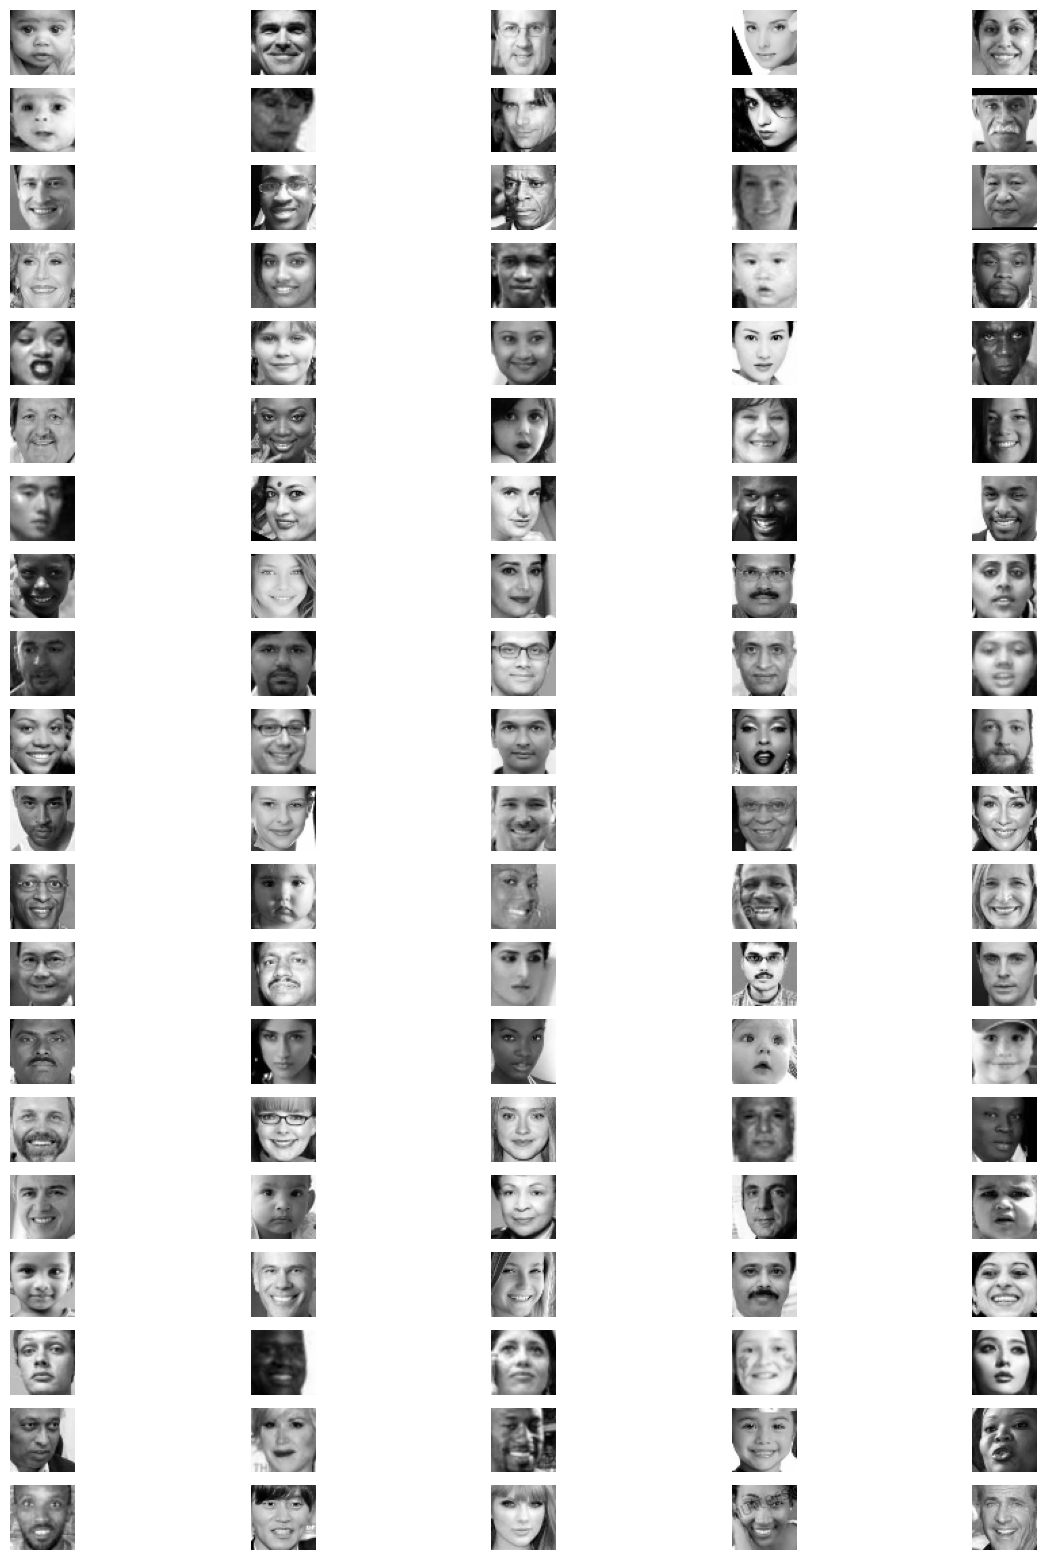

In [16]:
#plot 100 random grayscale images
fig, axes = plt.subplots(20, 5, figsize=(15,20))

for row in range(20):
  for col in range(5):
    random_face = np.random.choice(len(data))
    image = data['pixels'][random_face]

    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].axis('off')

plt.show()


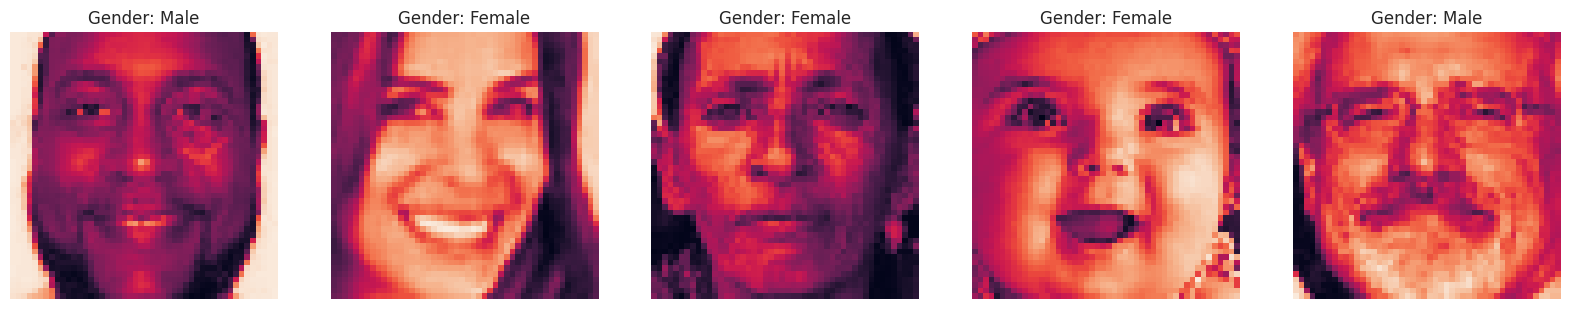

In [17]:
#plot some pictures
fig, axes = plt.subplots(1, 5, figsize=(20,10))

#random select and display 5 faces with their gander labels
for i in range(5):
  random_face = np.random.choice(len(data))
  gender = data['gender'][random_face]
  image = data['pixels'][random_face]
  axes[i].imshow(image)
  axes[i].set_title("Gender: {}".format("Female" if gender == 1 else "Male"))
  axes[i].axis('off')





Define Variable


In [18]:
input_shape = train_images.shape[1:]
n_epochs = 25
batch_size = 62

Model Architecture

In [19]:
#Import library keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [20]:
model  = Sequential()

model.add(Conv2D(128, kernel_size=(3,3), input_shape= input_shape, activation='relu'))

#add a 2d max pooling layer with  2*2 pool size
model.add(MaxPooling2D(pool_size=(2,2)))

#add bacthNormalization layer to nomalize layer input
model.add(BatchNormalization())

#add another convolution layer witj 128 filter and reLu activatio
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))

#add a max -pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# Add two more convolutional layers with 256 filters each, ReLU activation, and a combination of max-pooling, dropout, and BatchNormalization
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# Flatten the output from convolutional layers
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

#create output layer for binary classification using a sigmoid activation
model.add(Dense(1, activation='sigmoid'))

#compile the model with adam optimizer, bina
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()








/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,183,745 (4.52 MB)

 Trainable params: 1,182,721 (4.51 MB)

 Non-trainable params: 1,024 (4.00 KB)

##Early Stopping Mechanism

In [21]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

calllbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
]



In [33]:
#fit the model to traning data
history = model.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=n_epochs,
                    validation_data=(val_images, val_labels),
                    callbacks=calllbacks)

Epoch 1/25
288/306 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8573 - loss: 0.3305

KeyboardInterrupt: 

In [25]:
#Model Evalution
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)



Test Loss: 0.48507148027420044
Test Accuracy: 0.7603375315666199


# Confusion matrix

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step


Text(0.5, 32.249999999999986, 'Predicted')

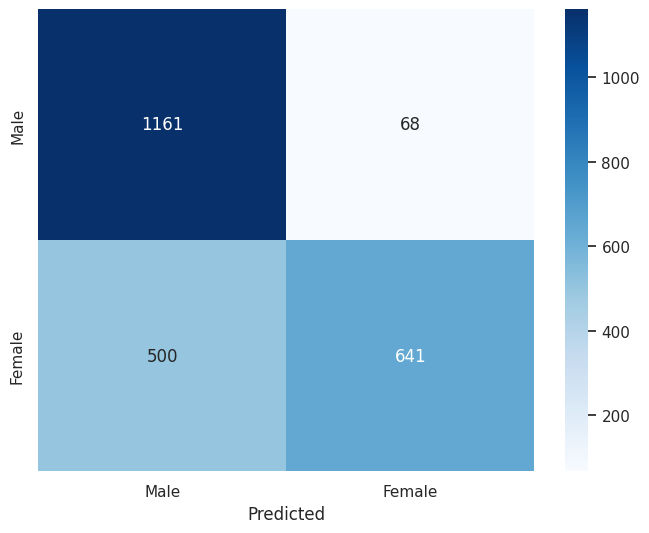

In [27]:
#generate prediction from model
prediction = model.predict(test_images).flatten()


label_true = test_labels

#convert prediction probability(0-1) to binary prediction (true/false)
label_pred = np.round(prediction)

cm = confusion_matrix(label_true, label_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            cmap='Blues',
            xticklabels=['Male', 'Female'],
            yticklabels=['Male', 'Female'])


plt.xlabel('Predicted')

In [32]:
#plotting traning history for various maatrics
for key in history.keys():
  plt.plot(history.history[key], label=key)
  plt.legend()
  plt.show()

NameError: name 'history' is not defined

#Model prediction

In [36]:
def predict_image(index, image, model):
  image = image[index]
  gender_predict = int(model.predict(np.array([image]))[0])

  gender = {0: 'Male', 1: 'Female'}

  plt.imshow(image)
  plt.title(f'Predicted Gender: {gender[gender_predict]}')
  plt.axis('off')
  plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


<ipython-input-36-85ca7fd5ff80>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gender_predict = int(model.predict(np.array([image]))[0])


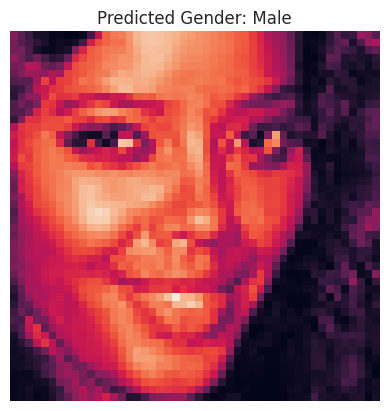

In [39]:
predicted_gender = predict_image(2000, test_images, model)

In [40]:
predicted_gender = predict_image(18964, test_images, model)

IndexError: index 18964 is out of bounds for axis 0 with size 2370